In [46]:
#| default_exp normalizing_flows
from nbdev.showdoc import *
import numpy as np
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import torch
from diffusion_curvature.comparisons import local_diffusion_entropy_of_matrix, diffusion_entropy_curvature_of_data
from diffusion_curvature.datasets import torus
from diffusion_curvature.core import plot_3d, diffusion_matrix, gaussian_kernel
# Reload any changes made to external files
%load_ext autoreload
%autoreload 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Mapping the Data to a Flat Space with Continuous Normalizing Flows

Previously, our diffusion curvature comparison was done using a uniform sampling of a flat space.
There's some variance here, due to random sampling, which is not ideal -- it mirrors the variance in sampling of the dataset itself, but compounds upon the problem by using a *different* random sampling. We observed that, with low-dimensional abundantly sampled data (like our torus), this variance was over 10x smaller than the variance within the torus, making comparisons possible.
But for more sparsely sampled data (including, by necessity, all high dimensional data), the variance due to sampling will be much greater. This raises the question: **can we learn a flat space with a sampling equivalent to the manifold's sampling?**

It's not obvious that this question makes sense. What does it mean for a plane to be sampled the same as a sphere? Both can be uniformly sampled with respect to volume, but volume is modulated by curvature. Considering any sufficiently large neighborhood of the sphere versus an equivalent neighborhood of the plane, the neighborhood in positive curvature will have fewer points, because it has less volume. It's impossible to place a sticker on a tennis ball; the flat sticker has "too many points" to biject onto the ball. 

However, at a sufficiently small neighborhood size, the question starts to make sense. It mirrors the aspiration to learn a logarithmic (or reverse-exponential) map, from the manifold to its tangent space. Equipped with this map, or a good approximation, we might be able to obtain a flat space with a (locally accurate) one-to-one mapping between points in the flat space and on the manifold.

This could be useful in a couple of ways:
1. Performing diffusion entropy in the equivalently sampled flat space. If a neighborhood of the manifold is sparsely sampled, it will bias the diffusion entropy towards being more negative than reality. If we create a flat space with a similarly sparse sampling, and a similarly biased entropy, the biases will cancel each other out in comparison.
2. If the map is a *really* good approximation of the logarithmic map, we could discern curvature just by locally measuring the changes in distances between points. This would put our bijection between points in the flat and manifold spaces to much better use, but it requires much more from the continuous normalizing flows.

The key challenges we anticipate include:
1. Mapping a sufficient number of points to perform 4-8 scales of diffusion may involve a neighborhood so large that the global geometry interferes with the sampling. For example, if mapping a 500 point neighborhood from the sphere into a flat space, these 500 points might include enough of the sphere's curvature that the flat space appears more sparsely sampled than the sphere, thus biasing the comparison space. (Interestingly, though, this bias could be used to measure the curvature...)

Here's the strategy: for every point $x_i$, we'll take the nearest $n$ points on the manifold, and treat this neighborhood of curvature like a self-contained dataset. We'll then learn a continuous normalizing flow from this neighborhood of curvature to a uniformly sampled flat space of a supplied dimension. We'll perform diffusion entropy in both spaces, bearing in mind these caveats:
- $k$ must be sufficiently large to minimize edge effects, where the diffusion, instead of continuing across the manifold, rebounds on itself.
- $k$ must be sufficiently small to avoid the mixing of geometry and sampling.

# Defining a Neural ODE
This code is adapted from Sumner Magruder's Neural ODE implementation.

In [47]:
import torch, torch.nn as nn, torch.utils.data as data, torch.nn.functional as F, torch.optim as optim
import ot
from torchdyn.core import NeuralODE
from torchdyn.datasets import *
import pytorch_lightning as pl
from tqdm.autonotebook import tqdm

### Dealing with Data

In standard nODE training, we use minibatches of points sampled from the entire dataset. 
In our case, we're only training *locally*, on the neighborhood of a point. Hence, the dataset will be a fixed number of points, operated without any fancy batching.


In [48]:
#| export
from sklearn.decomposition import PCA
import torch, torch.nn as nn, torch.utils.data as data, torch.nn.functional as F, torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import numpy as np
class ManifoldNeighborhoodDataset(data.Dataset):
    def __init__(self, X, n_neighbors, intrinsic_dimension):
        """
        Creates a dataset composed of the specified neighbors of the index point.
        """
        self.n_neighbors = n_neighbors
        self.X = torch.tensor(X).float()
        self.intrinsic_dimension = intrinsic_dimension
        self.scaler = MinMaxScaler(feature_range=(-1,1))
        
    def __len__(self):
        return int(self.n_neighbors)
    def __getitem__(self, idx):
        central_point = self.X[idx]
        # TODO: We presently assume that these neighborhoods are small enough that euclidean similarities are accurate
        distances_to_central_point = torch.linalg.norm(self.X - central_point, axis=1)
        neighbor_idxs = np.argsort(distances_to_central_point)[:self.n_neighbors]
        ambient_points = self.X[neighbor_idxs]
        pca = PCA(n_components=self.intrinsic_dimension)
        pca_points = pca.fit_transform(ambient_points.numpy())
        pca_points = self.scaler.fit_transform(pca_points)
        pca_points = torch.Tensor(pca_points)
        # scale pca'd points to unit (hyper)cube
        return ambient_points, pca_points
    
        

In [49]:
#| export
def dataloader_from_manifold_neighborhoods(X, n_neighbors):
    ds = ManifoldNeighborhoodDataset(X, intrinsic_dimension=2, n_neighbors=n_neighbors)
    dataloader = data.DataLoader(ds, batch_size=None,shuffle=False)
    return dataloader

### Neighborhoods of the Torus
Visualizations to help select an appropriate number of points.

In [50]:
X_torus, ks_torus = torus(n = 4000, use_guide_points=False) # TODO: Fix rejection sampling and so we actually get n_points = n

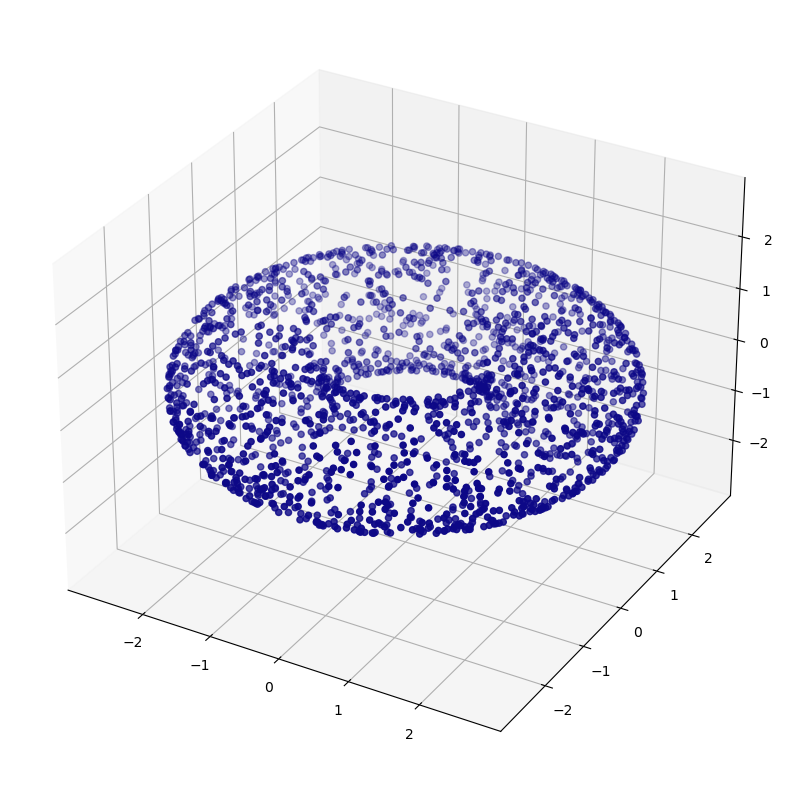

In [51]:
plot_3d(X_torus)

In [52]:
n_neighbors = 100
torus_dataset = ManifoldNeighborhoodDataset(X_torus, intrinsic_dimension=2, n_neighbors=n_neighbors)
torus_dataloader = data.DataLoader(torus_dataset, batch_size=None,shuffle=False)

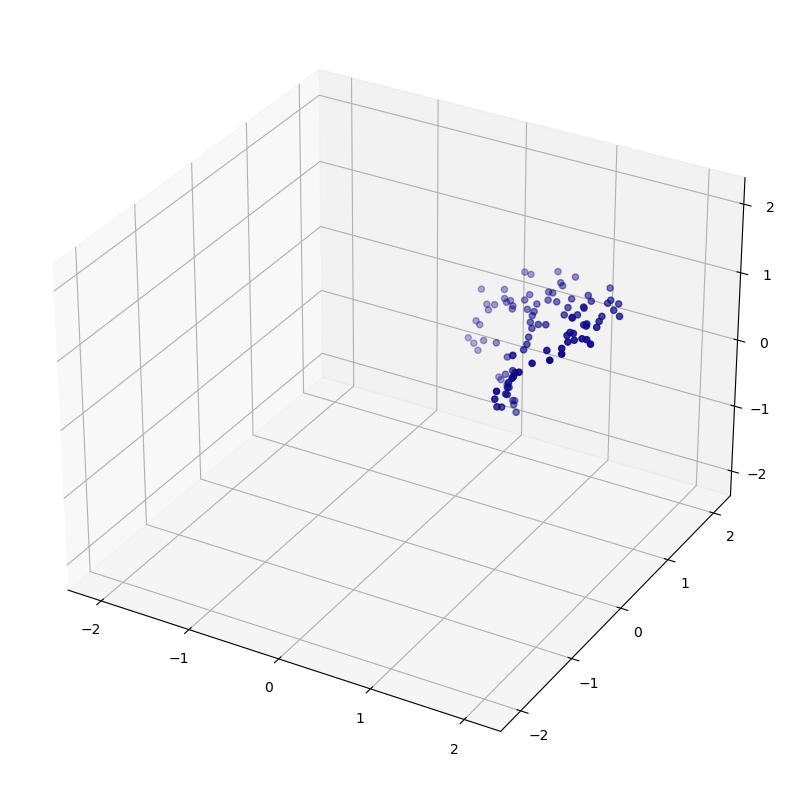

In [80]:
torus_nbhd, pca_torus_nbhd = torus_dataset.__getitem__(np.random.randint(len(X_torus)))
plot_3d(torus_nbhd)

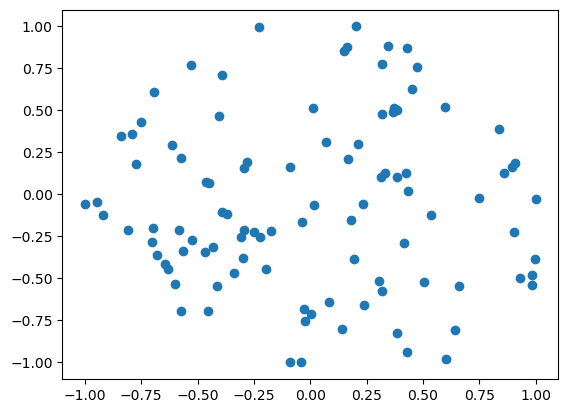

In [54]:
plt.scatter(pca_torus_nbhd[:,0],pca_torus_nbhd[:,1])

## Datasets for testing

This dataset returns the whole torus.

In [55]:
whole_torus_dataset = data.TensorDataset(torch.tensor(X_torus).float())
whole_torus_dataloader = data.DataLoader(whole_torus_dataset, batch_size=len(X_torus), shuffle=True)

This is a toy dataset from the torch dyn library:

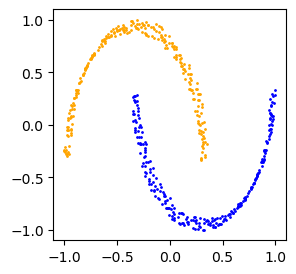

In [56]:
from torchdyn.datasets import *
import torch.utils.data as data

d = ToyDataset()
X_moons, yn_moons = d.generate(n_samples=512, noise=1e-1, dataset_type='moons')
scaler = MinMaxScaler(feature_range=(-1,1))
X_moons = scaler.fit_transform(X_moons)

colors = ['orange', 'blue']
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
for i in range(len(X_moons)):
    ax.scatter(X_moons[i,0], X_moons[i,1], s=1, color=colors[yn_moons[i].int()])

X_train = torch.Tensor(X_moons).to(device)
moons_trainset = data.TensorDataset(X_train)
moons_trainloader = data.DataLoader(moons_trainset, batch_size=len(X_moons), shuffle=True)

# Neural ODE Machinery

In [57]:
#| export
class FlowNet(nn.Module):
    def __init__(self, dimension ,activation='CELU'):
        super().__init__()
        act_fn = getattr(nn, activation)
        self.sigmoid = nn.Sigmoid()
        self.act_fn = act_fn
        
        self.seq = nn.Sequential(
            nn.Linear(dimension,16),
            act_fn(),

            nn.Linear(16,16),
            act_fn(),
            
            nn.Linear(16, 16),
            act_fn(),
            
            nn.Linear(16, 16),
            act_fn(),
            
            nn.Linear(16, 16),
            act_fn(),

            nn.Linear(16,dimension),
        )

    def forward(self, x):
        velocities = self.seq(x)
        # filter velocities outside the unit cube to zero
        filter = torch.sigmoid(100*(-x+0.9))*torch.sigmoid(100*(x+0.9))
        return velocities*filter

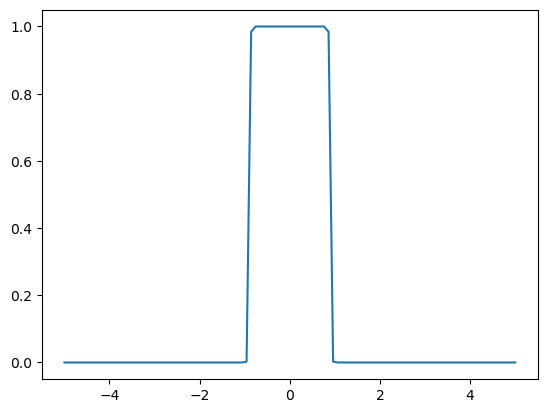

In [58]:
x = torch.linspace(-5,5,100)
ys = torch.sigmoid(100*(-x+0.9))*torch.sigmoid(100*(x+0.9))
plt.plot(x,ys)

In [59]:
#| export
class NegativeLogLikelihood(nn.Module):    
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model
    def __call__(self, transformed_points, J, prior):
        # logp(z_S) = logp(z_0) - \int_0^S trJ
        log_prob = prior.log_prob(transformed_points)[:,0] - J         
        loss = -torch.mean(log_prob)
        return loss
class NegativeLogLikelihoodQuaUniform(nn.Module):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model
    def __call__(self, transformed_points, J, prior):
        # logp(z_S) = logp(z_0) - \int_0^S trJ
        log_prob = prior.log_prob(transformed_points)
        # the uniform's prior function returns probs by dimension. We
        log_prob_z0 = torch.sum(log_prob,dim=1)
        log_prob_z1 = log_prob_z0 - J
        # Because we're comparing to the uniform distribution, the probs are all uniform - so this equates to minimizing the stretching within the domain, i.e.
        # penalizing the jacobian (which appears in the first column) to be as small as possible.           
        loss = -torch.mean(log_prob_z1)
        return loss

In [60]:
A = torch.rand(10,2)
torch.sum(A,dim=1)

tensor([0.7167, 1.9095, 0.3126, 1.4845, 0.3276, 0.9375, 0.8111, 1.4707, 1.2875,
        1.7984])

In [61]:
torch.log(torch.ones(4)/2)

tensor([-0.6931, -0.6931, -0.6931, -0.6931])

In [62]:
class  DeviationFromFlatness(nn.Module):    
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model    

    def __call__(self, X:torch.Tensor, prior):          
        transformed = self.model(X)
        
        return loss

In [63]:
#| export
import pytorch_lightning as pl
from torchdyn.nn import Augmenter
from torchdyn.models import CNF

class GreatFlattener(pl.LightningModule):
    def __init__(
        self, 
        model:nn.Module,        
        train_loader:data.DataLoader,
        input_dim:int,
        target_dim:int,
    ):
        super().__init__()
        
        # NOTE: model here is the Neural ODE
        self.model = model
        self.input_dim = input_dim #train_loader.dataset.X.shape[1]
        self.dim_of_target_distribution = target_dim #train_loader.dataset.intrinsic_dimension
        
        # The steps to integrate over
        self.t_span = torch.linspace(0, 1, 5)
        
        # Our dataset
        self.train_loader = train_loader
        
        # The distribution from which we are sampling to generate points
        self.prior = torch.distributions.uniform.Uniform(-torch.ones(input_dim)-0.01, torch.ones(input_dim)+0.01)
        # self.prior = torch.distributions.MultivariateNormal(torch.zeros(input_dim), torch.eye(input_dim))
        self.loss = NegativeLogLikelihoodQuaUniform(model)
        self.outside_bounds_penalty = 0
        self.augmenter = Augmenter(augment_idx=1, augment_dims=1) # used, before calling the CNF, to add an extra column which CNF can fill with the jacobian

    def train_dataloader(self):
        return self.train_loader
    
    def sample(self, shape):
        z = self.prior.sample(sample_shape=shape).to(torch.float32)
        # pad with zeros to extra dimensions
        # z = torch.hstack([z,torch.zeros(len(z),self.input_dim-self.dim_of_target_distribution)])
        return z.to(device)
        
    def forward(self, points, t_span=None, return_trajectory = False):
        if t_span is None:
            t_span = self.t_span
        points = points[0]
        # Add extra column of zeros, to be filled by the jacobian's trace by the CNF
        points_with_extra_dim = self.augmenter(points)
        # Pass prepared data into the Neural ODE and integrate through time
        t_eval, trajectory = self.model(points_with_extra_dim, t_span) 
        # get last component of trajectory and separate points from the Jacobian diagonal
        last_stop = trajectory[-1]
        J = last_stop[:,0]
        transformed_points = last_stop[:,1:]
        
        # If points have flowed outside of the support of the uniform distribution, trap them and bring them back
        # Trapping them, unfortunately, isn't differentiable. I'll instead scale the points along each dimension
        # for i in range(transformed_points.shape[1]):
        #     transformed_points[:,i][transformed_points[:,i]>1] = 1
        #     transformed_points[:,i][transformed_points[:,i]<-1] = -1
        # for i in range(transformed_points.shape[1]):
        #     transformed_points[:,i]  = transformed_points[:,i]/torch.max(transformed_points[:,i])

        # give huge penalty for leaving the support of the uniform distribution.
        distance_from_box = torch.max(torch.abs(transformed_points), torch.ones_like(transformed_points)) - torch.ones_like(transformed_points) 
        self.outside_bounds_penalty = torch.exp(torch.sum(distance_from_box))
        signed_distance_from_box = distance_from_box * torch.sign(transformed_points)

        # normalize points back in box
        # transformed_points = transformed_points - signed_distance_from_box

        if return_trajectory:
            return trajectory
        else:
            return transformed_points, J
    
    def training_step(self, points):    
        transformed_points, J = self.forward(points)
        loss = self.loss(transformed_points, J, self.prior)
        loss = loss # + self.outside_bounds_penalty
        self.log('loss', loss, prog_bar=True)
        self.log('outside box penalty', self.outside_bounds_penalty, prog_bar=True)
        return {'loss': loss}  
        
    @torch.no_grad()
    def generate_data(self, n_points):
        # Goes through the ODE in reverse
        # NOTE: regardless of how you implemented model this function _should_ work!

        points = [self.sample(torch.Size([n_points]))] # enclose in [] to match the form provided by the dataloader
        # integrating from 1 to 0
        reverse_t_span = torch.linspace(1, 0, 2)
        new_data, J = self.forward(points, t_span=reverse_t_span)
        return new_data
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=0.001, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.StepLR(optimizer, 100, gamma=0.99)
        return [optimizer], [scheduler]
    


# Training on a Toy Dataset

We'll first verify that the neural ode works by learning a transformation from the moons dataset (in 2d) to a uniform distribution, and then reversing the process.

In [64]:
trainable_flows = FlowNet(dimension=2)

from torchdyn.nn import Augmenter
from torchdyn.models import CNF
flow = CNF(trainable_flows)
model = NeuralODE(flow, sensitivity='adjoint', solver='dopri5')

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


In [65]:
# create our PyLightning learner to handle training steps
flattener = GreatFlattener(model, moons_trainloader, input_dim=2, target_dim=2)
flattener = flattener.to(device)

In [66]:
# create our PyLightning trainer to actually train the model
trainer = pl.Trainer(
    max_epochs=100,
    
    # NOTE: gradient clipping can help prevent exploding gradients
    gradient_clip_val=100,
    gradient_clip_algorithm='value',    
    log_every_n_steps=5,
    
    # NOTE: this should match your device i.e. if you set cuda above, this should be cuda. 
    # Otherwise it should be cpu. 
    accelerator="cpu",    
    
    # NOTE: you can set the maximum time you want to train your model
    max_time={'minutes': 5},    

    # NOTE: setting this to true will save your model every so often
    enable_checkpointing=False,
    accumulate_grad_batches=2
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


In [67]:
trainer.fit(flattener)


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/p

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


[[-0.95824295 -0.10403281]
 [ 0.99277264  0.8976932 ]
 [-0.6618996   0.93810093]
 ...
 [-0.704912   -0.78686553]
 [ 0.6516805  -0.6561154 ]
 [-0.8275612  -0.8090294 ]]


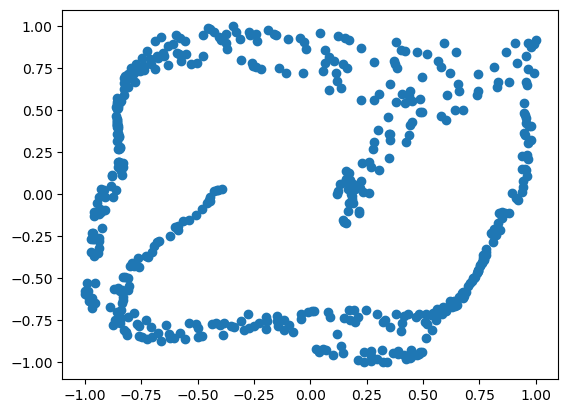

In [68]:
for x in moons_trainloader:
    dataset_after_flow, J = flattener(x, t_span=torch.linspace(0,1,2))
    dataset_after_flow = dataset_after_flow.detach().numpy()
    break
print(dataset_after_flow)
plt.scatter(dataset_after_flow[:,0],dataset_after_flow[:,1])

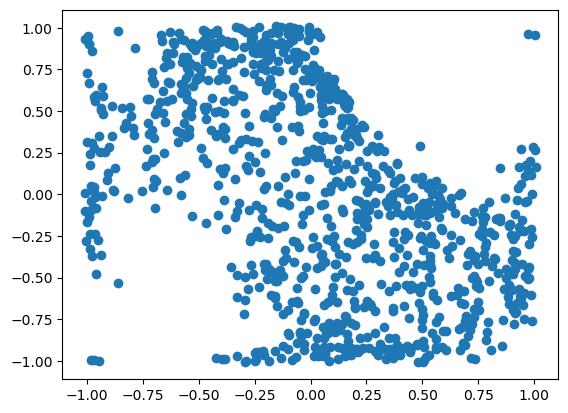

In [69]:
samples = flattener.generate_data(1000)
plt.scatter(samples[:,0], samples[:,1])

tensor([[ 0.8197, -0.2511],
        [ 0.0565,  1.8310],
        [-0.4739, -0.5693],
        [-1.0071,  1.6977],
        [-0.4272, -0.9225],
        [-0.1176,  1.8848],
        [-0.1483, -1.6132],
        [-0.3185,  0.0250],
        [-1.5896,  0.7762],
        [-0.2346, -2.0620],
        [ 0.3220,  0.9035],
        [ 2.1125, -0.9428],
        [-0.6511, -0.1452],
        [ 2.1467, -0.8048],
        [-0.1527, -0.3465],
        [-0.2822,  0.2181],
        [-0.1879, -0.3576],
        [-3.1034, -0.2711],
        [ 0.8837,  0.3151],
        [-1.7629, -0.1515],
        [-0.3107, -1.8181],
        [-0.6656, -0.9839],
        [ 0.0626,  0.5933],
        [-1.7923, -2.2166],
        [-0.4528,  2.2316],
        [-1.0240,  0.7834],
        [-0.2279,  0.7103],
        [-0.1366,  0.8651],
        [-0.5096, -0.4624],
        [-1.0631,  0.8307],
        [ 0.1442,  0.8215],
        [-1.5120, -0.2042],
        [ 1.7666, -0.4683],
        [ 0.8034, -0.5916],
        [-2.1010, -0.5864],
        [-0.4494, -0

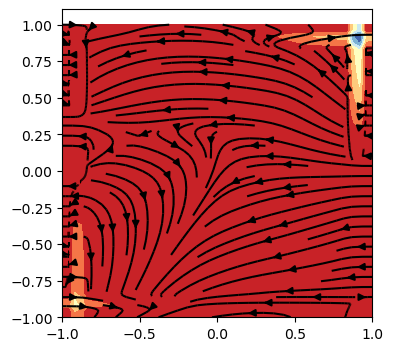

In [70]:
# evaluate vector field
trajectory = flattener([torch.tensor(X_moons).float()],t_span=torch.linspace(0,1,5), return_trajectory=True).detach()

n_pts = 50
x = torch.linspace(trajectory[:,:,1].min(), trajectory[:,:,1].max(), n_pts)
y = torch.linspace(trajectory[:,:,2].min(), trajectory[:,:,2].max(), n_pts)
X, Y = torch.meshgrid(x, y) 
z = torch.cat([X.reshape(-1,1), Y.reshape(-1,1)], 1)
z = flattener.augmenter(z)
f = flattener.model.vf(0,z).cpu().detach()
fx, fy = f[:,0], f[:,1] ; fx, fy = fx.reshape(n_pts , n_pts), fy.reshape(n_pts, n_pts)
# plot vector field and its intensity
fig = plt.figure(figsize=(4, 4)) ; ax = fig.add_subplot(111)
ax.streamplot(X.numpy().T, Y.numpy().T, fx.numpy().T, fy.numpy().T, color='black')
ax.contourf(X.T, Y.T, torch.sqrt(fx.T**2+fy.T**2), cmap='RdYlBu')
transformed_points = torch.randn(50,2)
transformed_points

# An sklearn like interface to the nODE

We've now verified that the nODE machinery works, and can reproduce a reasonable facsimile of the moons dataset, as well as turn the dataset into an approximation of gaussian noise. If trained longer, it would likely have greater fidelity. 

Our next step is simple: wrapping the above into a function that produces an nODE-flattened version of *any* supplied data.

In [71]:
#| export
from torchdyn.nn import Augmenter
import pytorch_lightning as pl
import torch
from torchdyn.models import CNF, NeuralODE

class neural_flattener():
    def __init__(self, device, max_epochs=1000):
        self.device = device
        self.max_epochs = max_epochs

    def fit_transform(self, X):
        # create dataloader from input tensor
        X = torch.Tensor(X).float()
        trainset = data.TensorDataset(X)
        trainloader = data.DataLoader(trainset, batch_size=len(X), shuffle=True)    
        # define flows and ode, initialize model
        dim = X.shape[1]
        trainable_flows = FlowNet(dimension=dim)
        flow = CNF(trainable_flows)
        self.ode = NeuralODE(flow, sensitivity='adjoint', solver='dopri5')
        # create our PyLightning learner to handle training steps
        self.flattener = GreatFlattener(self.ode, trainloader, input_dim=dim, target_dim=dim)
        self.flattener = self.flattener.to(self.device)
        # train 
        self.trainer = pl.Trainer(
            max_epochs=self.max_epochs,
            
            # NOTE: gradient clipping can help prevent exploding gradients
            gradient_clip_val=100,
            gradient_clip_algorithm='value',    
            log_every_n_steps=5,
            
            # NOTE: this should match your device i.e. if you set cuda above, this should be cuda. 
            # Otherwise it should be cpu. 
            accelerator="cpu",    
            
            # NOTE: you can set the maximum time you want to train your model
            max_time={'minutes': 5},    

            # NOTE: setting this to true will save your model every so often
            enable_checkpointing=False,
            accumulate_grad_batches=2
        )
        self.trainer.fit(self.flattener)
        # afterwards, take the transformed data
        transformed_data, J = self.flattener([X], t_span=torch.linspace(0,1,2))
        return transformed_data.detach()

In [72]:
NF = neural_flattener(device=device, max_epochs=1000)

In [73]:
transformed_moons = NF.fit_transform(X_moons)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


Training: 0it [00:00, ?it/s]

Time limit reached. Elapsed time is 0:05:00. Signaling Trainer to stop.


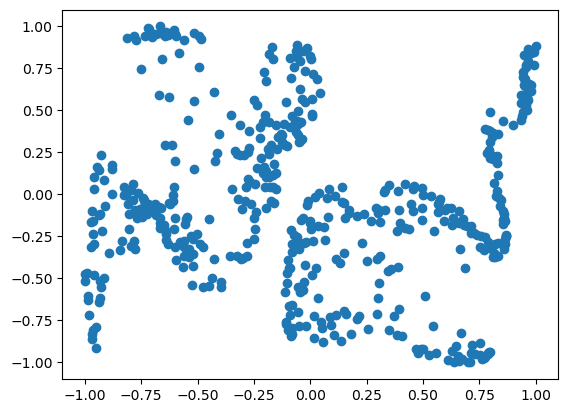

In [74]:
plt.scatter(transformed_moons[:,0],transformed_moons[:,1])